<a href="https://colab.research.google.com/github/pradeepvaghela/skills-copilot-codespaces-vscode/blob/main/SHM_NN_36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbCallback
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

#WANDB_API_KEY="fbda c5bd 6a0e 10d38 3771 e753 574c a586 d112 2ee"
#fbdac5bd6a0e10d383771e753574ca586d1122ee
wandb.init(project="shm_google_collab") #https://wandb.ai/


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

In [ ]:
df = pd.read_csv("Al_37_with_randomization_37_v1.csv",sep=',',names=["X","Y","Z","W","R"], skiprows=1) #Read data.csv

# Step 1: Get unique labels in the 'label' column
unique_labels = sorted(df['R'].unique())

# Step 2: Create a mapping from original label (e.g., 11, 12, 13) to integer (0, 1, 2, ...)
label_mapping = {label: new_label for new_label, label in enumerate(unique_labels)}

# Step 3: Apply the mapping to the 'label' column
df['R'] = df['R'].map(label_mapping)

X=(df.drop(columns=['R'])).to_numpy() #data points are stored in X
#X=(df.drop(columns=['R_new'])).to_numpy() #data points are stored in X
Y=((df['R'].values))     #results are stored in Y

train_size = 0.2  # Splits train and test according to this ratio (Values: [0,1])
val_size = 0.2    #This will be created from values remainig in test after the initial split

# scaler = StandardScaler(with_mean=True, with_std=True)
# X = scaler.fit_transform(X)
# pca = PCA(3)
# X = pca.fit_transform(X)



x_train, x_test, y_train, y_test = train_test_split(X, np.around(Y), test_size=(1-(train_size)), random_state=120) #Split data into training and testing sets

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=(1-val_size), random_state=120) #Split data into training and testing sets

y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat = tf.keras.utils.to_categorical(y_val)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X.shape)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(16649999, 4)
(3329999, 4)
(2664000, 4)
(10656000, 4)
(3329999, 37)
(2664000, 37)
(10656000, 37)


In [ ]:
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.layer_1_size = 24
config.layer_2_size = 24
config.layer_3_size = 24
config.layer_4_size = 24
config.learn_rate = 0.001
#config.learn_rate_low = 0.0001
#config.kernel_size = 3
#config.pool_size = 2
#config.decay = 1e-6
#config.momentum = 0.9
config.n_epochs = 13
batch = 500


In [ ]:
model = Sequential()
model.add(Dense(config.layer_1_size, input_dim=4)) #Change the input dimensions as required
model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(config.layer_2_size))
model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(config.layer_3_size))
model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(config.layer_4_size))
model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(37, activation='softmax'))

In [ ]:
# Callbacks for early stopping
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor="accuracy", verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="accuracy", verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=config.learn_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=['accuracy'])

In [ ]:
start = time.time()
model.fit(x_train, y_train_cat, epochs=config.n_epochs, batch_size=batch, validation_data=(x_val, y_val_cat))
stop = time.time()
print(f"Training time: {stop - start}s")

In [ ]:
model.save('/content/XXXX.keras') #Enter Save location

In [ ]:
model = tf.keras.models.load_model('XXXX.keras') #Open a Model


In [ ]:
accuracy = model.evaluate(x_test[2000000:3000000], y_test_cat[2000000:3000000], verbose=1)
print('Accuracy: %.2f' % (accuracy[1]*100))

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.4643 - loss: 1.7285
Accuracy: 46.46


In [ ]:
y_pred=model.predict(x_test[:10000], verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.68
[[0.14 0.56]
 [0.58 0.33]]


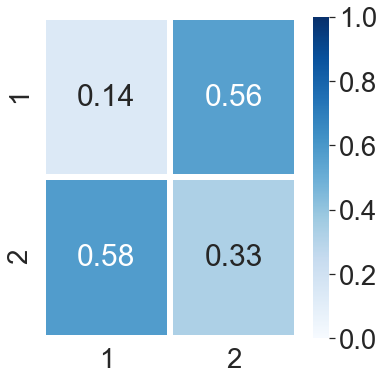

In [ ]:
# Use for 4 defects

z = sklearn.metrics.confusion_matrix(y_test[:1000].astype(int), np.argmax(y_pred[:1000],axis=1))
con_mat_norm = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=2)
diag = np.diag(con_mat_norm)
print(diag[0])
print(diag[1:].reshape(2,2))
reshape = diag[1:].reshape(2,2)

tick_labels = [1,2] #

figure = plt.figure(figsize=(6, 6))
sns.heatmap(reshape, linewidths=5, annot=True,cmap=plt.cm.Blues, vmin=0, vmax=1, xticklabels=tick_labels, yticklabels=tick_labels)
# sns.heatmap(z, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=2.5)
plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# tikzplotlib.save("mytikz_2.tex")
#plt.savefig('KNN_36_20_2_5.png')
# figure.savefig("Accuracy Matrix/SIM_NN_36_PCA_2.pdf", bbox_inches='tight')
plt.show()

1.0
[[0.25 0.3  0.4  0.46 0.45 0.66]
 [0.17 0.32 0.6  0.19 0.42 0.46]
 [0.28 0.33 0.56 0.23 0.52 0.58]
 [0.57 0.29 0.76 0.41 0.48 0.57]
 [0.46 0.3  0.5  0.2  0.26 0.82]
 [1.   0.14 0.39 0.71 0.45 0.65]]


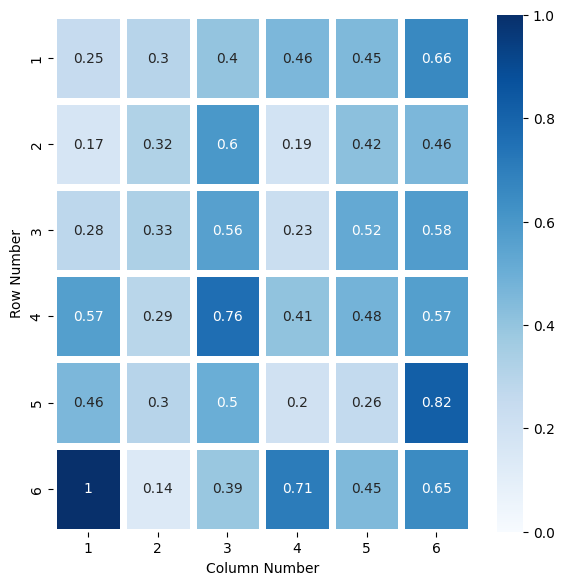

In [ ]:
# Use for 36 defects

z = sklearn.metrics.confusion_matrix(y_test[:1000].astype(int), np.argmax(y_pred[:1000],axis=1))
con_mat_norm = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=2)
diag = np.diag(con_mat_norm)
#diag = np.diag(z)
print(diag[0])
print(diag[1:].reshape(6,6))
reshape = diag[1:].reshape(6,6)

tick_labels = [1,2,3,4,5,6] #

figure = plt.figure(figsize=(6, 6))
sns.heatmap(reshape, linewidths=5, annot=True,cmap=plt.cm.Blues, vmin=0, vmax=1, xticklabels=tick_labels, yticklabels=tick_labels)
# sns.heatmap(z, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=1.5)
plt.tight_layout()
plt.ylabel('Row Number')
plt.xlabel('Column Number')
# tikzplotlib.save("mytikz_2.tex")
#plt.savefig('KNN_36_20_2_5.png')
# figure.savefig("Accuracy Matrix/SIM_NN_36_PCA_2.pdf", bbox_inches='tight')
figure.savefig("Aluminum_randomised_37_ANN.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# ************************************ KNN ***************************************************

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 20)
#initally neighbour are 20 but with 2 we get high accuracy in matlb so lowering it to 5 here to check
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [ ]:
y_pred = knn.predict(x_test[2000000:4000000])

In [ ]:
y_pred = knn.predict(x_test[:])

print('Accuracy:',knn.score(x_test, y_test))


In [ ]:
print('Accuracy:',knn.score(x_test[2000000:4000000], y_test[2000000:4000000]))

In [ ]:
# Use for 4 defects

z = sklearn.metrics.confusion_matrix(y_test[:10000].astype(int), np.argmax(y_pred[:10000],axis=1))
con_mat_norm = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=2)
diag = np.diag(con_mat_norm)
print(diag[0])
print(diag[1:].reshape(2,2))
reshape = diag[1:].reshape(2,2)

tick_labels = [1,2] #

figure = plt.figure(figsize=(6, 6))
sns.heatmap(reshape, linewidths=5, annot=True,cmap=plt.cm.Blues, vmin=0, vmax=1, xticklabels=tick_labels, yticklabels=tick_labels)
# sns.heatmap(z, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=2.5)
plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# tikzplotlib.save("mytikz_2.tex")
#plt.savefig('KNN_36_20_2_5.png')
# figure.savefig("Accuracy Matrix/SIM_NN_36_PCA_2.pdf", bbox_inches='tight')
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tikzplotlib

# y_pred=model.predict_classes(x_test[:], verbose=1)
z = sklearn.metrics.confusion_matrix(y_test.astype(int)[2000000:4000000], y_pred)
con_mat_norm = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=2)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Blues)
# sns.heatmap(z, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=1)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# tikzplotlib.save("mytikz_2.tex")
plt.savefig('yo.png')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2000000, 11126363]

In [ ]:
# Use for 36 defects _ modified way of showing

z = sklearn.metrics.confusion_matrix(y_test[:].astype(int), y_pred[:].astype(int))
con_mat_norm = z.astype('float') / z.sum(axis=1)[:, np.newaxis]
#con_mat_norm = np.around(z.astype('float') / (z.sum(axis=1)[:, np.newaxis] + 1e-10), decimals=2)
#con_mat_norm = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=2)
diag = np.diag(con_mat_norm)
#diag = np.diag(z)
print(diag[0])
print(diag[1:].reshape(6,6))
reshape = diag[1:].reshape(6,6)

tick_labels = [1,2,3,4,5,6] #

figure = plt.figure(figsize=(6, 6))
sns.heatmap(reshape, linewidths=5, annot=True, fmt='.2%', cmap=plt.cm.Blues, vmin=0, vmax=1, xticklabels=tick_labels, yticklabels=tick_labels)
# sns.heatmap(z, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=1)
plt.tight_layout()
plt.ylabel('Row Number')
plt.xlabel('Column Number')
# tikzplotlib.save("mytikz_2.tex")
#plt.savefig('KNN_36_20_2_5.png')
# figure.savefig("Accuracy Matrix/SIM_NN_36_PCA_2.pdf", bbox_inches='tight')
figure.savefig("AL_random_37_knn_20_percentage.pdf", bbox_inches='tight')
plt.show()